In this notebook, we will be trying to understand how to block the effect of noise on Images. 

### First, we will be looking at the problem of optimal transport between absolute 0 and noise:
For $\epsilon \ which \ has \ distribution \ of \ i.i.d \ (0,\sigma^2)$

$W_1(0, \epsilon)= W_1(0_+ + \epsilon_- , 0_- + \epsilon_+) = W_1(\epsilon_- , \epsilon_+) \leq f(\sigma)
$

Besides that, we would like to find the closed expression for calculating classic euclidean distance which will be an anchor for how well we do 

In [2]:
import numpy as np
import ot
import cvxpy as cp
import matplotlib.pyplot as plt
from utils.Visualizations import *
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
import seaborn as sns

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
def plot_marginals(X, p, q, title, first_distribution_title = 'Source dist: p', second_distribution_title = 'Target dist: q'):
    """
    Plot the marginals of the transport map
    :param X: linear space in which the distributions are defined
    :param p: source distribution
    :param q: target distribution
    :param title: title of the plot
    :return: None, plot the distributions
    """
    plt.figure(figsize=(10, 4))
    plt.bar(X, p, alpha=0.5, label=first_distribution_title, width=1/len(p))
    plt.bar(X, q, alpha=0.5, label=second_distribution_title, width=1/len(q))
    plt.title(title),
    plt.legend()
    plt.show()

In [215]:
n_p = 100
noise_param = 1e-3
X = np.linspace(0,1,n_p)

p = np.zeros(n_p)
q = np.random.normal(0, noise_param, n_p)

C = np.zeros([n_p,n_p],dtype=np.float64)

dist_f1 = lambda a,b : abs(a-b)
dist_f2 = lambda a,b : (a-b)**2
for it1 in range(n_p):
    for it2 in range(n_p):
        C[it1,it2] = dist_f2(X[it1],X[it2])

<Figure size 600x600 with 0 Axes>

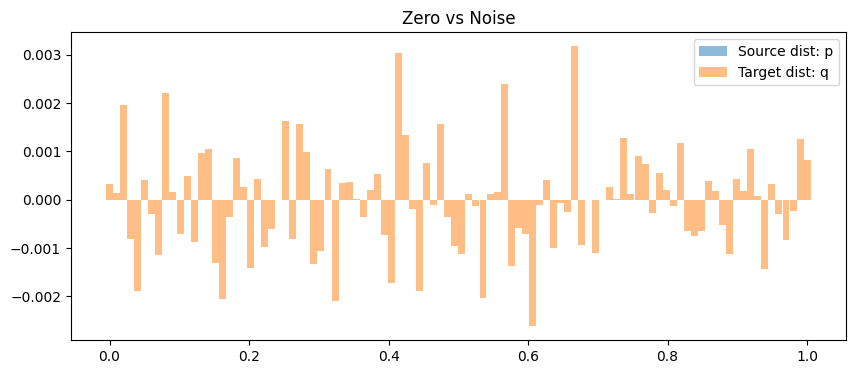

In [189]:
plt.figure(figsize=(6,6))
#TODO: add type of graph I would want in the plot_marginals function, default will be box
plot_marginals(X, p, q, 'Zero vs Noise')

<Figure size 600x600 with 0 Axes>

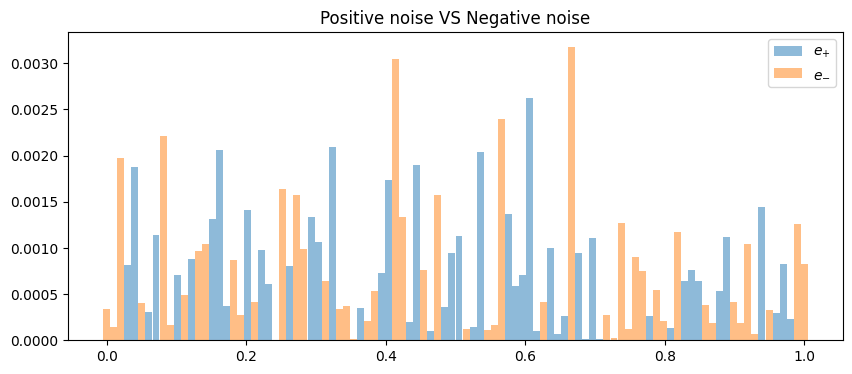

In [190]:
p_pos, p_neg = split_signed_measure(p)
q_pos, q_neg = split_signed_measure(q)

p_new = p_pos + q_neg
q_new = p_neg + q_pos

plt.figure(figsize=(6,6))
plot_marginals(X = X, p = p_new, q = q_new, title = 'Positive noise VS Negative noise', first_distribution_title=r'$e_{+}$', 
               second_distribution_title=r'$e_{-}$')

In [191]:
p_new.max()

0.002619042314192479

In [192]:
q.max()

0.0031769371015022856

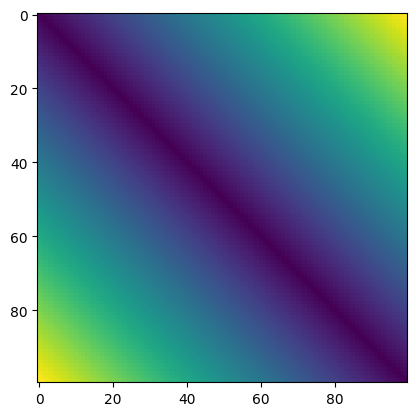

In [210]:
plt.imshow(C)

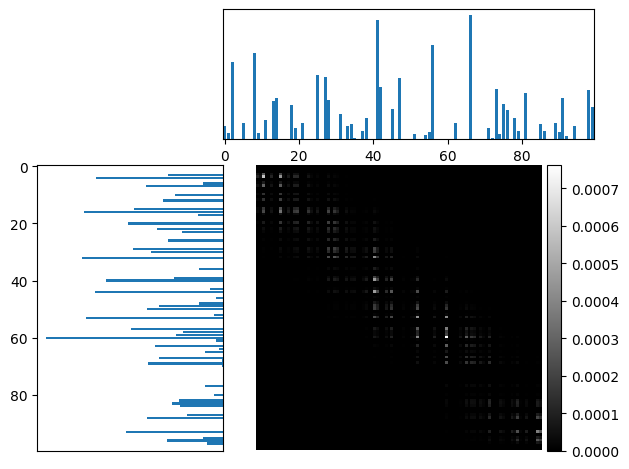

In [195]:
plan, log = ot.unbalanced.mm_unbalanced(a = p_new, b = q_new, M = C, reg_m=10, log=True)
plot_transport_map_with_marginals(p_new, q_new, plan, '')

In [196]:
a = p_new
b = q_new
M = C

@interact(reg_m=FloatSlider(min=0.5, max=10.0, step=0.1, value=10), a=fixed(a), b=fixed(b), M=fixed(M))
def interactive_UOT(reg_m=10):
    plan, log = ot.unbalanced.mm_unbalanced(a=a, b=b, M=M, reg_m=reg_m, log=True)
    fig = plot_transport_map_with_marginals(a=a,b=b,M=plan,title='interactive reg_param')
    #fig = plt.imshow(plan, cmap='gray')
    #plt.title('interactive reg_param')
    print("The sum of source distribution:", a.sum())
    print("sum of target distribution:", b.sum())
    print("sum of transport plan:", plan.sum())
    print("The cost of the transport(including divergences):", log['cost']) 
    plt.show()

interactive(children=(FloatSlider(value=10.0, description='reg_m', max=10.0, min=0.5), Output()), _dom_classes…

In [197]:
emd_distance = plan.sum()  #this is not exactly the emd distance since we don't take the divergences into account.

In [198]:
euclidean_distance = np.linalg.norm(p - q)

In [199]:
euclidean_distance

0.010730031041697185

In [200]:
emd_distance

0.040793582608323616

## Check a few transport plans simultaneously:

In [201]:
from tqdm import tqdm

n_experiments = 20
results_emd_all = [0,0,0,0,0]
results_emd_sum = [0,0,0,0,0]
results_euc_all = [0,0,0,0,0]
n_p = 100
noise_param = 1
reg_parameter = [0.5, 2, 10, 100]  #cost of creating mass

for i in tqdm(range(len(reg_parameter))):
    results_emd = []
    results_emd_s = []
    results_euc = []
    for j in range(n_experiments):
        p = np.zeros(n_p)
        q = np.random.normal(0, noise_param, n_p)

        p_pos, p_neg = split_signed_measure(p)
        q_pos, q_neg = split_signed_measure(q)

        p_new = p_pos + q_neg
        q_new = p_neg + q_pos

        plan, log = ot.unbalanced.mm_unbalanced(a = p_new, b = q_new, M = C, reg_m=reg_parameter[i], log=True)
        results_emd.append(log['cost'])
        results_emd_s.append(plan.sum())

        results_euc.append(np.linalg.norm(p-q))

    results_emd_all[i] = np.mean(results_emd)
    results_emd_sum[i] = np.mean(results_emd_s)
    results_euc_all[i] = np.mean(results_euc)

print('The average emd distance is:', results_emd_all)
print('The average euclid distance is:', results_euc_all)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.17s/it]

The average emd distance is: [0.1812731728192698, 0.39461873000658926, 0.6356110961162542, 3.013492355932358, 0]
The average euclid distance is: [9.655724731371654, 9.640086241018967, 9.766365027213489, 10.158037591031125, 0]


In [8]:
print('The average emd distance is:', results_emd_all)
print('The average sum of transport plans is:', results_emd_sum)
print('The average euclid distance is:', results_euc_all)

The average emd distance is: [10.553098623221796, 35.315012947586226, 72.74122182063192, 162.08283022508732, 0]
The average sum of transport plans is: [9.590024448288903, 24.4216206903944, 33.098160354746696, 38.813097958728214, 0]
The average euclid distance is: [9.982385810208136, 10.038449273995692, 9.704612027790999, 10.011311080685562, 0]


What would be an optimal parameter to consider? Seems like the plans which make sense are going to give us a larger distance than the euclidean one. Although, the fact that it's not strictly bigger is strange.

The emd distance in this constilation is at least as big as the euclidean distance. since we move every piece of mass at least one block. I think this will also be the general case and therefore maybe it will be better to look at something beyond the result itself. 

## KL - doesn't work for the trivial case since the supports are completely disjoint

In [92]:
## Looking at the KL divergence
from scipy.stats import entropy

KL = entropy(pk=p_new,qk=q_new)

In [93]:
KL

inf

## Trying out the tirangle inequality

In [216]:
alpha = make_1D_gauss(n_p, np.floor(3 * n_p / 8.), 10.).flatten()
beta = make_1D_gauss(n_p, np.floor(5 * n_p / 8.), 10.).flatten()
gamma = make_1D_gauss(n_p, np.floor(4 * n_p / 8.), 10.).flatten()

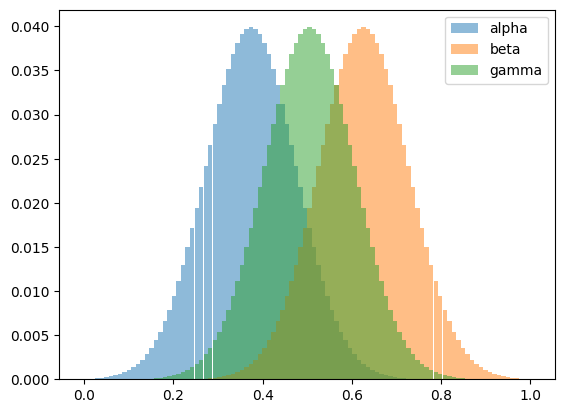

In [217]:
plt.bar(X,alpha, alpha=0.5, width=1 / len(alpha), label='alpha')
plt.bar(X,beta, alpha=0.5, width=1 / len(alpha), label ='beta')
plt.bar(X,gamma, alpha=0.5, width=1 / len(alpha), label='gamma')
plt.legend()
plt.show()

In [218]:
reg_param = 1

a_b_dist, log_a_b = ot.unbalanced.mm_unbalanced(a=alpha,b=beta,M=C,reg_m=reg_param, log=True)
a_g_dist, log_a_g = ot.unbalanced.mm_unbalanced(a=alpha,b=gamma,M=C,reg_m=reg_param, log=True)
g_b_dist, log_b_g = ot.unbalanced.mm_unbalanced(a=gamma,b=beta,M=C,reg_m=reg_param, log=True)

In [219]:
a_b_dist.shape

(100, 100)

In [220]:
a_b_euc = np.linalg.norm(alpha - beta)

Plot the transport maps, something feels really off. not sure what it is but I think that the triangle inequality does not hold

In [221]:
print('The distance in the classic emd between the gaussians is:', calc_transport_pot_emd(alpha, beta, C)[1])

print('The euclidean distance between the gaussians is:',a_b_euc)

print('The distance in the unbalanced emd with a regularization parameter of', reg_param, 'emd between the gaussians is:', log_a_b['cost'])

The distance in the classic emd between the gaussians is: 0.06373416233408974
The euclidean distance between the gaussians is: 0.2111888650972068
The distance in the unbalanced emd with a regularization parameter of 1 emd between the gaussians is: 0.057982314213797854


Now let us look at the transport maps:

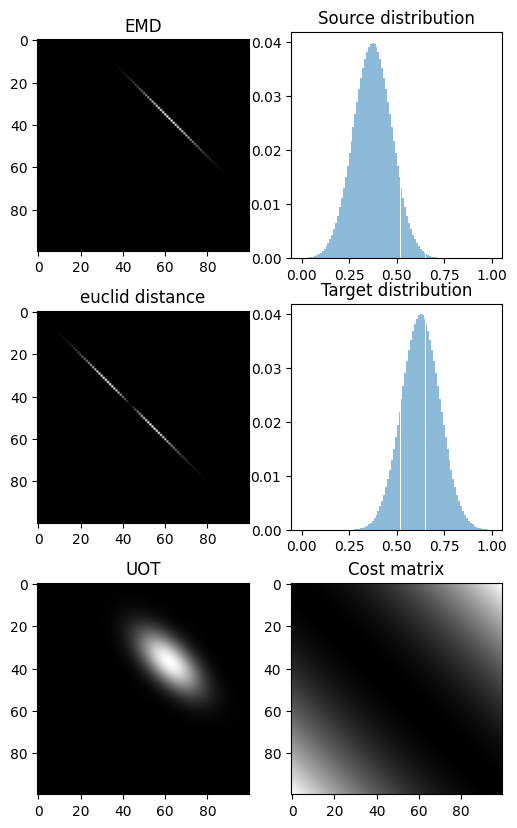

In [224]:
fig = plt.figure(figsize=(6, 10))

fig.add_subplot(3, 2, 1)
plt.title('EMD')
plt.imshow(calc_transport_pot_emd(alpha,beta,C)[0], cmap='gray')

fig.add_subplot(3, 2, 3)
plt.title('euclid distance')
plt.imshow(np.abs(np.diag(alpha_new - beta_new)), cmap='gray')

fig.add_subplot(3, 2, 5)
plt.title('UOT')
plt.imshow(ot.unbalanced.mm_unbalanced(a=alpha.flatten(), b=beta.flatten(), M=C, reg_m=10), cmap='gray')

fig.add_subplot(3, 2, 2)
plt.title('Source distribution')
plt.bar(X,alpha, alpha=0.5, width=1 / len(alpha))

fig.add_subplot(3, 2, 4)
plt.title('Target distribution')
plt.bar(X,beta, alpha=0.5, width=1 / len(beta))

fig.add_subplot(3, 2, 6)
plt.title('Cost matrix')
plt.imshow(C, cmap='gray')

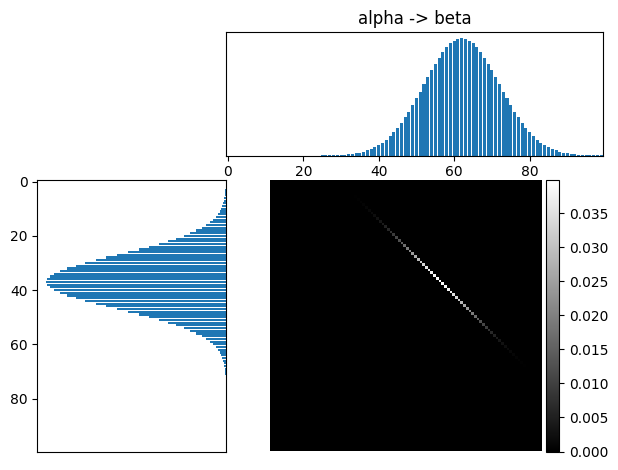

In [227]:
plot_transport_map_with_marginals(a=alpha, b=beta, M=calc_transport_pot_emd(alpha,beta,C)[0], title='alpha -> beta')

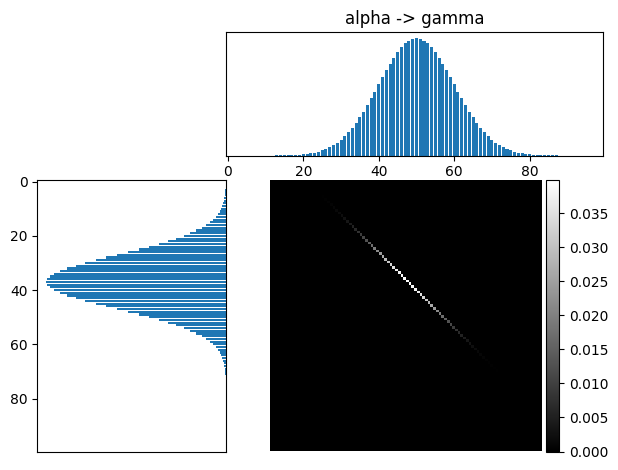

In [228]:
plot_transport_map_with_marginals(a=alpha, b=gamma, M=calc_transport_pot_emd(alpha,gamma,C)[0], title='alpha -> gamma')

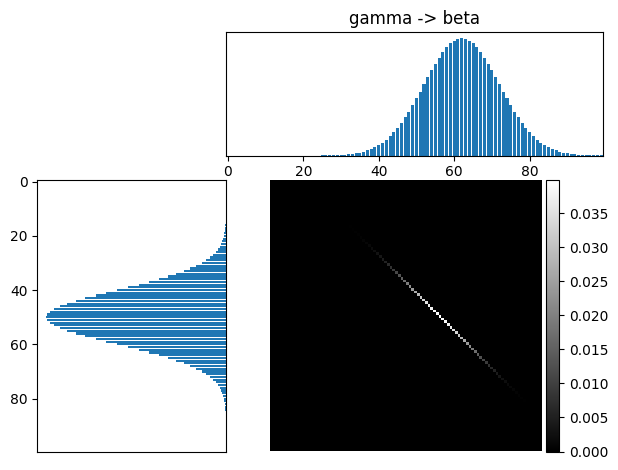

In [229]:
plot_transport_map_with_marginals(a=gamma, b=beta, M=calc_transport_pot_emd(gamma,beta,C)[0], title='gamma -> beta')

Comparing the classic EMD weights

In [232]:
a_b_emd = calc_transport_pot_emd(alpha,beta,C)[1]
a_g_emd = calc_transport_pot_emd(alpha,gamma,C)[1]
g_b_emd = calc_transport_pot_emd(beta,gamma,C)[1]

print('alpha beta dist:', a_b_emd)
print('alpha gamma dist:', a_g_emd)
print('gamma beta dist:', g_b_emd)

alpha beta dist: 0.06373416233408974
alpha gamma dist: 0.017234282130444697
gamma beta dist: 0.01468427146896496


triangle inequality does not hold for p values bigger than 1, even for standard emd

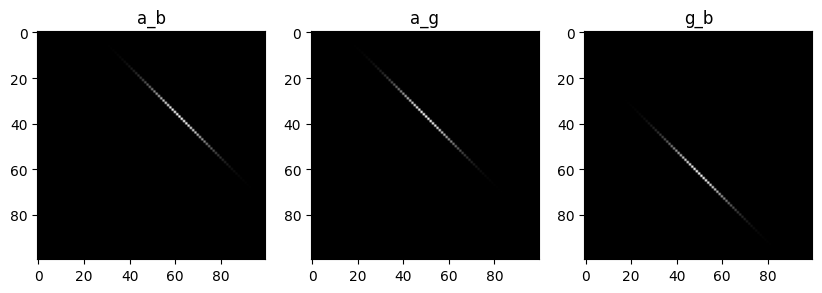

In [231]:
a_b_emd = calc_transport_pot_emd(alpha,beta,C)[0]
a_g_emd = calc_transport_pot_emd(alpha,gamma,C)[0]
g_b_emd = calc_transport_pot_emd(beta,gamma,C)[0]

fig = plt.figure(figsize=(10,6))

fig.add_subplot(1,3,1)
plt.title('a_b')
plt.imshow(a_b_emd, cmap = 'gray')
fig.add_subplot(1,3,2)
plt.title('a_g')
plt.imshow(a_g_emd, cmap='gray')
fig.add_subplot(1,3,3)
plt.title('g_b')
plt.imshow(g_b_emd, cmap='gray')

## Option for another part

11

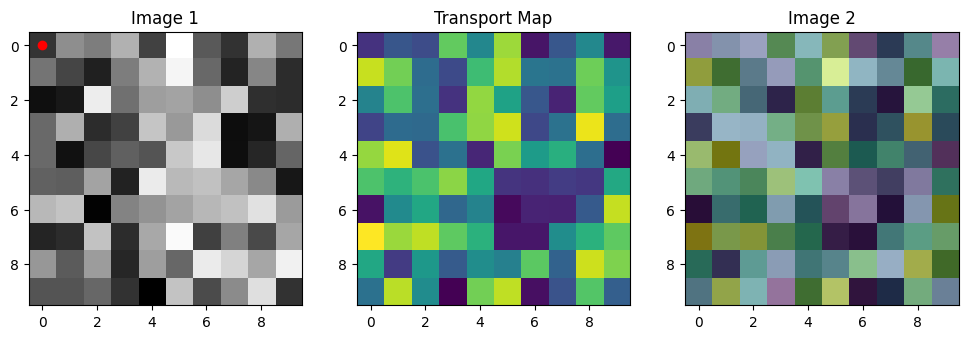

In [160]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Initialize figure and axes
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Fake image1 and image2
image1 = np.random.rand(10, 10)
image2 = np.random.rand(10, 10)

# Generate some fake EMD transport map for demonstration
transport_map = np.random.rand(10, 10, 10, 10)
transport_map /= transport_map.sum((2, 3), keepdims=True)

def plot_transport(x, y, transport_map, image1, image2, axs):
    axs[0].clear()
    axs[1].clear()
    axs[2].clear()
    
    axs[0].set_title('Image 1')
    axs[0].imshow(image1, cmap='gray')
    axs[0].scatter([y], [x], c='red')
    
    axs[1].set_title('Transport Map')
    axs[1].imshow(transport_map[int(x), int(y), :, :], cmap='viridis')
    
    axs[2].set_title('Image 2')
    axs[2].imshow(image2, cmap='gray')
    axs[2].imshow(transport_map[int(x), int(y), :, :], cmap='viridis', alpha=0.5)
    
    fig.canvas.draw()

def on_click(event, plot_func, transport_map, image1, image2, axs):
    x, y = event.ydata, event.xdata
    if event.inaxes is None or x is None or y is None:
        return
    
    x, y = round(x), round(y)
    if 0 <= x < 10 and 0 <= y < 10:
        plot_func(x, y, transport_map, image1, image2, axs)

# Initial plot
plot_transport(0, 0, transport_map, image1, image2, axs)

# Create a function that includes the extra parameters
on_click_with_params = partial(on_click, plot_func=plot_transport, transport_map=transport_map, image1=image1, image2=image2, axs=axs)

# Connect the click event to the plot update function
fig.canvas.mpl_connect('button_press_event', on_click_with_params)
